## Task 1 - Zero-Shot Evaluation

In [2]:
#@title GPU / Python / Torch sanity
import os, sys, subprocess, json, platform, torch
print("Python :", sys.version)
print("CUDA   :", torch.version.cuda)
print("Torch  :", torch.__version__)
print("Device :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
!nvidia-smi || true

Python : 3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:29:10) [GCC 14.3.0]
CUDA   : 12.8
Torch  : 2.9.0+cu128
Device : NVIDIA RTX 6000 Ada Generation
Mon Nov 10 06:00:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    Off |   00000000:21:00.0 Off |                  Off |
| 30%   37C    P8             16W /  300W |    3092MiB /  49140MiB | 

In [3]:
# some imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from transformers import CLIPProcessor, CLIPModel, CLIPVisionModel, logging
from peft import LoraConfig, get_peft_model, TaskType
from torchinfo import summary
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import json
import warnings

/mnt/data1/graduate/yuxin/anaconda3/envs/lora_clip/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# some settings
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_ID = "openai/clip-vit-large-patch14" # pre-trained CLIP model (ViT-L/14)
BATCH_SIZE = 8 # adjust based on your GPU memory
gradient_accumulation_steps = 1 # adjust based on your GPU memory
# For Linear Probe & LoRA
NUM_EPOCHS = 10
print(f"Using device: {DEVICE}")

Using device: cuda


In [5]:
# CLIP settings
# --- Load CLIP Processor ---
processor = CLIPProcessor.from_pretrained(MODEL_ID)
# --- Define a transform to process images for CLIP ---
class CLIPTransform:
    def __init__(self, processor):
        self.processor = processor

    def __call__(self, image):
        # The processor expects a PIL image or list of images
        # It returns a dict, we extract 'pixel_values'
        # .squeeze(0) removes the batch dimension the processor adds
        return self.processor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)

clip_transform = CLIPTransform(processor)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [6]:
# dataset related imports
from torchvision.datasets import Flowers102 
from datasets import load_dataset
from torch.utils.data import Dataset

# --- Flowers102 ---
# prepare Flowers102 dataset
flowers102_test_dts = Flowers102(root="./data", split="test", transform=clip_transform, download=True)
print(f"Total test samples: {len(flowers102_test_dts)}")

# prepare class names for Flowers102
with open("cat_to_name.json", "r") as f:
    flowers102_cat_to_name = json.load(f)
flowers102_class_names = [flowers102_cat_to_name[str(i)] for i in range(1, 103)]
print(f"Number of Flowers102 classes: {len(flowers102_class_names)}")

# --- CUB-200-2011 ---
birds_200 = load_dataset("bentrevett/caltech-ucsd-birds-200-2011")

# Create a wrapper class to make HuggingFace dataset compatible with PyTorch DataLoader
# 建立包裝類別使 HuggingFace dataset 相容於 PyTorch DataLoader
class CUBDatasetWrapper(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = item['label']
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

cub_bird_test_dts = CUBDatasetWrapper(birds_200["test"], transform=clip_transform)
print(f"Total test samples: {len(cub_bird_test_dts)}")

# prepare class names for CUB-200-2011
# CUB-200 has 200 bird species, labels are 0-199
# 獲取 CUB-200 的真實類別名稱
# 使用資料集的 features 來獲取類別名稱
cub_bird_class_names = birds_200["train"].features['label'].names
print(f"Number of CUB-200 classes: {len(cub_bird_class_names)}")
print(f"Sample bird class names: {cub_bird_class_names[:5]}")

# === Create DataLoaders ===
flowers102_test_loader = DataLoader(flowers102_test_dts, batch_size=BATCH_SIZE, shuffle=False)
cub_bird_test_loader = DataLoader(cub_bird_test_dts, batch_size=BATCH_SIZE, shuffle=False)
print("DataLoaders created successfully!")


Total test samples: 6149
Number of Flowers102 classes: 102
Total test samples: 5794
Number of CUB-200 classes: 200
Sample bird class names: ['001.Black_footed_Albatross', '002.Laysan_Albatross', '003.Sooty_Albatross', '004.Groove_billed_Ani', '005.Crested_Auklet']
DataLoaders created successfully!


### 載入模型 建立文字提示模板

In [7]:
print("--- Starting Method 1: Zero-Shot Classification ---")

# === 1. Load the full CLIP model ===
model = CLIPModel.from_pretrained(MODEL_ID).to(DEVICE)
model.eval()
print(f"Model loaded: {MODEL_ID}")

# === 2. Create and encode text prompts ===
# 定義多組不同的 prompt templates 進行比較
def create_text_prompts(class_names, templates=None):
    """Create text prompts for zero-shot classification
    建立用於零樣本分類的文字提示
    """
    if templates is None:
        # Handcrafted prompts (Default from CLIP paper)
        # 手工設計的提示（CLIP 論文中的預設值）
        templates = [
            "a photo of a {}",
        ]
    
    all_prompts = []
    for class_name in class_names:
        for template in templates:
            all_prompts.append(template.format(class_name))
    
    return all_prompts

# 定義不同的 prompt templates 組合
# 預設 prompt（來自 CLIP 論文）
default_templates = ["a photo of a {}"]

# 自訂 prompt 組合 1：多樣化描述
custom_templates_1 = [
    "a photo of a {}",
    "a picture of a {}",
    "an image of a {}",
]

# 自訂 prompt 組合 2：更具描述性
custom_templates_2 = [
    "a photo of a {}, a type of flower" if "flower" in "context" else "a photo of a {}, a type of bird",
    "a close-up photo of a {}",
    "a beautiful {}",
]

# 自訂 prompt 組合 3：更詳細的上下文
custom_templates_3_flowers = [
    "a photo of a {}, a type of flower",
    "a botanical photo of a {}",
    "a detailed image of {} flower",
]

custom_templates_3_birds = [
    "a photo of a {}, a type of bird",
    "a wildlife photo of a {}",
    "a detailed image of {} bird",
]

print("\n準備評估不同的 prompt templates...")


--- Starting Method 1: Zero-Shot Classification ---
Model loaded: openai/clip-vit-large-patch14

準備評估不同的 prompt templates...


### 使用預設 Prompt 進行評估

In [ ]:
# === 3. Evaluate on the test set ===
# 定義評估函數以便重複使用
def evaluate_zero_shot(model, test_loader, text_features, desc="Evaluation"):
    """
    執行零樣本評估
    Args:
        model: CLIP 模型
        test_loader: 測試資料載入器
        text_features: 預先計算的文字特徵
        desc: 進度條描述
    Returns:
        accuracy: 準確率
        predictions: 預測結果列表
        labels: 真實標籤列表
    """
    correct = 0
    total = 0
    predictions = []
    labels_list = []
    
    with torch.no_grad():
        # 使用半精度推理以提升速度和降低記憶體使用
        with torch.cuda.amp.autocast(dtype=torch.float16):
            for images, labels in tqdm(test_loader, desc=desc):
                images = images.to(DEVICE)
                
                # Get image features
                # 獲取影像特徵
                image_features = model.get_image_features(pixel_values=images)
                image_features = image_features / image_features.norm(dim=-1, keepdim=True)
                
                # Calculate similarity
                # 計算相似度
                similarity = (image_features @ text_features.T)
                preds = similarity.argmax(dim=-1)
                
                correct += (preds.cpu() == labels).sum().item()
                total += labels.size(0)
                
                predictions.extend(preds.cpu().tolist())
                labels_list.extend(labels.tolist())
    
    accuracy = correct / total
    return accuracy, predictions, labels_list

# === Flowers102 資料集評估 ===
print("\n" + "="*80)
print("評估 Flowers102 資料集（使用預設 prompt）")
print("="*80)

# 建立預設 prompts
flowers_prompts_default = create_text_prompts(flowers102_class_names, default_templates)
print(f"建立了 {len(flowers_prompts_default)} 個 prompts")
print(f"範例 prompts: {flowers_prompts_default[:3]}")

# 編碼文字提示
flowers_text_inputs = processor(text=flowers_prompts_default, return_tensors="pt", padding=True, truncation=True).to(DEVICE)

with torch.no_grad():
    # 使用半精度進行文字編碼以提升速度和降低記憶體使用
    with torch.cuda.amp.autocast(dtype=torch.float16):
        flowers_text_features_default = model.get_text_features(**flowers_text_inputs)
        flowers_text_features_default = flowers_text_features_default / flowers_text_features_default.norm(dim=-1, keepdim=True)

# 如果使用了多個 templates，需要對每個類別的特徵取平均
num_templates = len(default_templates)
flowers_text_features_default = flowers_text_features_default.view(len(flowers102_class_names), num_templates, -1).mean(dim=1)

# 執行評估
flowers102_accuracy_default, flowers102_predictions_default, flowers102_labels = evaluate_zero_shot(
    model, 
    flowers102_test_loader, 
    flowers_text_features_default,
    desc="Flowers102 (Default Prompt)"
)

print(f"\n✅ Flowers102 評估完成")
print(f"準確率: {flowers102_accuracy_default*100:.2f}%")

# === CUB-200 資料集評估 ===
print("\n" + "="*80)
print("評估 CUB-200 資料集（使用預設 prompt）")
print("="*80)

# 建立預設 prompts
birds_prompts_default = create_text_prompts(cub_bird_class_names, default_templates)
print(f"建立了 {len(birds_prompts_default)} 個 prompts")
print(f"範例 prompts: {birds_prompts_default[:3]}")

# 編碼文字提示
birds_text_inputs = processor(text=birds_prompts_default, return_tensors="pt", padding=True, truncation=True).to(DEVICE)

with torch.no_grad():
    # 使用半精度進行文字編碼以提升速度和降低記憶體使用
    with torch.cuda.amp.autocast(dtype=torch.float16):
        birds_text_features_default = model.get_text_features(**birds_text_inputs)
        birds_text_features_default = birds_text_features_default / birds_text_features_default.norm(dim=-1, keepdim=True)

# 如果使用了多個 templates，需要對每個類別的特徵取平均
birds_text_features_default = birds_text_features_default.view(len(cub_bird_class_names), num_templates, -1).mean(dim=1)

# 執行評估
cub_bird_accuracy_default, cub_bird_predictions_default, cub_bird_labels = evaluate_zero_shot(
    model, 
    cub_bird_test_loader, 
    birds_text_features_default,
    desc="CUB-200 (Default Prompt)"
)

print(f"\n✅ CUB-200 評估完成")
print(f"準確率: {cub_bird_accuracy_default*100:.2f}%")



=== 使用預設 Prompt (Default: 'a photo of a {}') ===
Created 102 prompts for Flowers102
Created 200 prompts for CUB-200

--- Evaluating on Flowers102 (Default Prompt) ---


Zero-Shot Evaluation (Flowers102-Default): 100%|██████████| 769/769 [02:08<00:00,  5.97it/s]



--- Evaluating on CUB-200 (Default Prompt) ---


Zero-Shot Evaluation (CUB-200-Default): 100%|██████████| 725/725 [01:56<00:00,  6.22it/s]


預設 Prompt 結果:
Flowers102 Zero-Shot Test Accuracy: 74.04%
CUB-200 Zero-Shot Test Accuracy: 49.98%


### 使用自訂 Prompt 1 進行評估（多樣化描述）

In [14]:
print("\n=== 使用自訂 Prompt 1 (多樣化: photo/picture/image) ===")

# Create prompts for Flowers102 with custom template 1
# 套用模板產生句子
flowers_prompts_custom1 = create_text_prompts(flowers102_class_names, custom_templates_1)
print(f"Created {len(flowers_prompts_custom1)} prompts for Flowers102")

# Encode text features
# 句子轉tokens
flowers_text_inputs = processor(text=flowers_prompts_custom1, return_tensors="pt", padding=True, truncation=True).to(DEVICE)
with torch.no_grad():
    # token 轉 embeddings
    flowers_text_features_custom1 = model.get_text_features(**flowers_text_inputs)
    # 把多個模板的 embedding 取平均
    flowers_text_features_custom1 = flowers_text_features_custom1.view(len(flowers102_class_names), -1, flowers_text_features_custom1.shape[-1]).mean(dim=1)
    # 把平均後的 embedding 正規化 (變成單位向量)
    flowers_text_features_custom1 = flowers_text_features_custom1 / flowers_text_features_custom1.norm(dim=-1, keepdim=True)

# Create prompts for CUB-200
birds_prompts_custom1 = create_text_prompts(cub_bird_class_names, custom_templates_1)
print(f"Created {len(birds_prompts_custom1)} prompts for CUB-200")

# Encode text features
birds_text_inputs = processor(text=birds_prompts_custom1, return_tensors="pt", padding=True, truncation=True).to(DEVICE)
with torch.no_grad():
    birds_text_features_custom1 = model.get_text_features(**birds_text_inputs)
    birds_text_features_custom1 = birds_text_features_custom1.view(len(cub_bird_class_names), -1, birds_text_features_custom1.shape[-1]).mean(dim=1)
    birds_text_features_custom1 = birds_text_features_custom1 / birds_text_features_custom1.norm(dim=-1, keepdim=True)

# Evaluate
print("\n--- Evaluating on Flowers102 (Custom Prompt 1) ---")
flowers102_accuracy_custom1, flowers102_predictions_custom1, _ = evaluate_zero_shot(
    model, flowers102_test_loader, flowers_text_features_custom1, "Zero-Shot Evaluation (Flowers102-Custom1)"
)

print("\n--- Evaluating on CUB-200 (Custom Prompt 1) ---")
cub_bird_accuracy_custom1, cub_bird_predictions_custom1, _ = evaluate_zero_shot(
    model, cub_bird_test_loader, birds_text_features_custom1, "Zero-Shot Evaluation (CUB-200-Custom1)"
)

print(f"\n{'='*60}")
print(f"自訂 Prompt 1 結果:")
print(f"Flowers102 Zero-Shot Test Accuracy: {flowers102_accuracy_custom1 * 100:.2f}%")
print(f"CUB-200 Zero-Shot Test Accuracy: {cub_bird_accuracy_custom1 * 100:.2f}%")
print(f"{'='*60}")



=== 使用自訂 Prompt 1 (多樣化: photo/picture/image) ===
Created 306 prompts for Flowers102
Created 600 prompts for CUB-200

--- Evaluating on Flowers102 (Custom Prompt 1) ---


Zero-Shot Evaluation (Flowers102-Custom1): 100%|██████████| 6149/6149 [01:42<00:00, 60.08it/s]



--- Evaluating on CUB-200 (Custom Prompt 1) ---


Zero-Shot Evaluation (CUB-200-Custom1): 100%|██████████| 5794/5794 [01:31<00:00, 63.34it/s]


自訂 Prompt 1 結果:
Flowers102 Zero-Shot Test Accuracy: 74.32%
CUB-200 Zero-Shot Test Accuracy: 51.42%


### 使用自訂 Prompt 2 進行評估（具有上下文資訊）

In [15]:
print("\n=== 使用自訂 Prompt 2 (具有領域上下文資訊) ===")

# Create prompts for Flowers102 with custom template 3 (domain-specific)
flowers_prompts_custom2 = create_text_prompts(flowers102_class_names, custom_templates_3_flowers)
print(f"Created {len(flowers_prompts_custom2)} prompts for Flowers102")

# Encode text features
flowers_text_inputs = processor(text=flowers_prompts_custom2, return_tensors="pt", padding=True, truncation=True).to(DEVICE)
with torch.no_grad():
    flowers_text_features_custom2 = model.get_text_features(**flowers_text_inputs)
    flowers_text_features_custom2 = flowers_text_features_custom2.view(len(flowers102_class_names), -1, flowers_text_features_custom2.shape[-1]).mean(dim=1)
    flowers_text_features_custom2 = flowers_text_features_custom2 / flowers_text_features_custom2.norm(dim=-1, keepdim=True)

# Create prompts for CUB-200 with custom template 3 (domain-specific)
birds_prompts_custom2 = create_text_prompts(cub_bird_class_names, custom_templates_3_birds)
print(f"Created {len(birds_prompts_custom2)} prompts for CUB-200")

# Encode text features
birds_text_inputs = processor(text=birds_prompts_custom2, return_tensors="pt", padding=True, truncation=True).to(DEVICE)
with torch.no_grad():
    birds_text_features_custom2 = model.get_text_features(**birds_text_inputs)
    birds_text_features_custom2 = birds_text_features_custom2.view(len(cub_bird_class_names), -1, birds_text_features_custom2.shape[-1]).mean(dim=1)
    birds_text_features_custom2 = birds_text_features_custom2 / birds_text_features_custom2.norm(dim=-1, keepdim=True)

# Evaluate
print("\n--- Evaluating on Flowers102 (Custom Prompt 2) ---")
flowers102_accuracy_custom2, flowers102_predictions_custom2, _ = evaluate_zero_shot(
    model, flowers102_test_loader, flowers_text_features_custom2, "Zero-Shot Evaluation (Flowers102-Custom2)"
)

print("\n--- Evaluating on CUB-200 (Custom Prompt 2) ---")
cub_bird_accuracy_custom2, cub_bird_predictions_custom2, _ = evaluate_zero_shot(
    model, cub_bird_test_loader, birds_text_features_custom2, "Zero-Shot Evaluation (CUB-200-Custom2)"
)

print(f"\n{'='*60}")
print(f"自訂 Prompt 2 結果:")
print(f"Flowers102 Zero-Shot Test Accuracy: {flowers102_accuracy_custom2 * 100:.2f}%")
print(f"CUB-200 Zero-Shot Test Accuracy: {cub_bird_accuracy_custom2 * 100:.2f}%")
print(f"{'='*60}")



=== 使用自訂 Prompt 2 (具有領域上下文資訊) ===
Created 306 prompts for Flowers102
Created 600 prompts for CUB-200

--- Evaluating on Flowers102 (Custom Prompt 2) ---


Zero-Shot Evaluation (Flowers102-Custom2): 100%|██████████| 6149/6149 [01:44<00:00, 58.77it/s]



--- Evaluating on CUB-200 (Custom Prompt 2) ---


Zero-Shot Evaluation (CUB-200-Custom2): 100%|██████████| 5794/5794 [01:32<00:00, 62.45it/s]


自訂 Prompt 2 結果:
Flowers102 Zero-Shot Test Accuracy: 79.02%
CUB-200 Zero-Shot Test Accuracy: 55.23%


### Prompt 比較結果總表


Zero-Shot Classification Results - Prompt Comparison
                                        Prompt Template Flowers102 Accuracy (%) CUB-200 Accuracy (%)
                Default (CLIP paper)\n"a photo of a {}"                   74.04                49.98
      Custom 1 (Diverse)\n"photo/picture/image of a {}"                   74.32                51.42
Custom 2 (Domain-specific)\n"flower/bird + descriptive"                   79.02                55.23

最佳 Flowers102 結果: Custom 2 (79.02%)
最佳 CUB-200 結果: Custom 2 (55.23%)


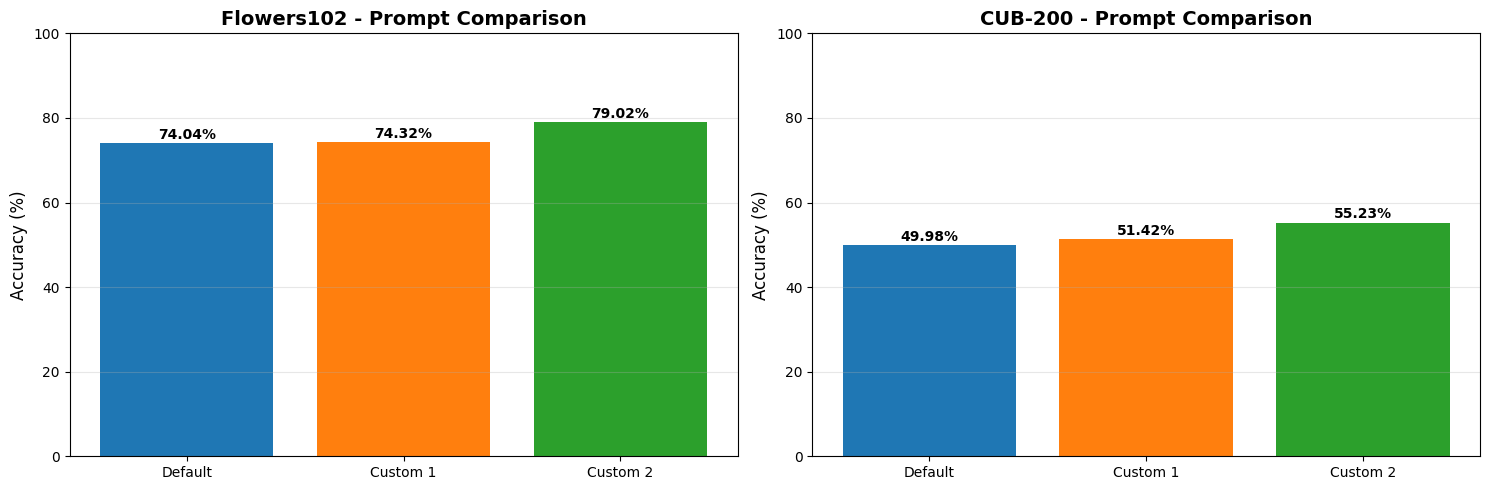


後續分析將使用最佳 prompt 的結果


In [16]:
# === 5. 比較不同 Prompt 的結果並製作表格 ===
import pandas as pd

# 整理結果到 DataFrame
results_data = {
    'Prompt Template': [
        'Default (CLIP paper)\n"a photo of a {}"',
        'Custom 1 (Diverse)\n"photo/picture/image of a {}"',
        'Custom 2 (Domain-specific)\n"flower/bird + descriptive"'
    ],
    'Flowers102 Accuracy (%)': [
        f"{flowers102_accuracy_default * 100:.2f}",
        f"{flowers102_accuracy_custom1 * 100:.2f}",
        f"{flowers102_accuracy_custom2 * 100:.2f}"
    ],
    'CUB-200 Accuracy (%)': [
        f"{cub_bird_accuracy_default * 100:.2f}",
        f"{cub_bird_accuracy_custom1 * 100:.2f}",
        f"{cub_bird_accuracy_custom2 * 100:.2f}"
    ]
}

results_df = pd.DataFrame(results_data)

print("\n" + "="*80)
print("Zero-Shot Classification Results - Prompt Comparison")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# 找出最佳結果
best_flowers_idx = np.argmax([flowers102_accuracy_default, flowers102_accuracy_custom1, flowers102_accuracy_custom2])
best_birds_idx = np.argmax([cub_bird_accuracy_default, cub_bird_accuracy_custom1, cub_bird_accuracy_custom2])

prompt_names = ['Default', 'Custom 1', 'Custom 2']
print(f"\n最佳 Flowers102 結果: {prompt_names[best_flowers_idx]} ({[flowers102_accuracy_default, flowers102_accuracy_custom1, flowers102_accuracy_custom2][best_flowers_idx] * 100:.2f}%)")
print(f"最佳 CUB-200 結果: {prompt_names[best_birds_idx]} ({[cub_bird_accuracy_default, cub_bird_accuracy_custom1, cub_bird_accuracy_custom2][best_birds_idx] * 100:.2f}%)")

# 繪製比較圖
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Flowers102 比較
flowers_accs = [flowers102_accuracy_default * 100, flowers102_accuracy_custom1 * 100, flowers102_accuracy_custom2 * 100]
ax1.bar(prompt_names, flowers_accs, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Flowers102 - Prompt Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 100])
for i, v in enumerate(flowers_accs):
    ax1.text(i, v + 1, f'{v:.2f}%', ha='center', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# CUB-200 比較
birds_accs = [cub_bird_accuracy_default * 100, cub_bird_accuracy_custom1 * 100, cub_bird_accuracy_custom2 * 100]
ax2.bar(prompt_names, birds_accs, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('CUB-200 - Prompt Comparison', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 100])
for i, v in enumerate(birds_accs):
    ax2.text(i, v + 1, f'{v:.2f}%', ha='center', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 使用最佳 prompt 的結果進行後續分析
# 將最佳結果儲存為主要結果
if best_flowers_idx == 0:
    flowers102_predictions = flowers102_predictions_default
    flowers102_accuracy = flowers102_accuracy_default
elif best_flowers_idx == 1:
    flowers102_predictions = flowers102_predictions_custom1
    flowers102_accuracy = flowers102_accuracy_custom1
else:
    flowers102_predictions = flowers102_predictions_custom2
    flowers102_accuracy = flowers102_accuracy_custom2

if best_birds_idx == 0:
    cub_bird_predictions = cub_bird_predictions_default
    cub_bird_accuracy = cub_bird_accuracy_default
elif best_birds_idx == 1:
    cub_bird_predictions = cub_bird_predictions_custom1
    cub_bird_accuracy = cub_bird_accuracy_custom1
else:
    cub_bird_predictions = cub_bird_predictions_custom2
    cub_bird_accuracy = cub_bird_accuracy_custom2

print(f"\n後續分析將使用最佳 prompt 的結果")


### 詳細分類報告

In [17]:
# Classification report
# 分類報告
print("\n" + "="*80)
print("Flowers102 Classification Report (前 20 個類別)")
print("="*80)
print(classification_report(flowers102_labels, flowers102_predictions, 
                          target_names=flowers102_class_names, 
                          labels=list(range(20)), zero_division=0))

print("\n" + "="*80)
print("CUB-200 Classification Report (前 20 個類別)")
print("="*80)
print(classification_report(cub_bird_labels, cub_bird_predictions, 
                          target_names=cub_bird_class_names, 
                          labels=list(range(20)), zero_division=0))

# 計算每個類別的準確率並找出表現最好和最差的類別
from sklearn.metrics import precision_recall_fscore_support

# Flowers102 per-class accuracy
flowers_precision, flowers_recall, flowers_f1, flowers_support = precision_recall_fscore_support(
    flowers102_labels, flowers102_predictions, labels=list(range(102)), zero_division=0
)

# 找出最佳和最差的 5 個類別
flowers_best_idx = np.argsort(flowers_f1)[-5:][::-1]
flowers_worst_idx = np.argsort(flowers_f1)[:5]

print("\n" + "="*80)
print("Flowers102 - 表現最好的 5 個類別:")
print("="*80)
for idx in flowers_best_idx:
    print(f"{flowers102_class_names[idx]:30s} - F1: {flowers_f1[idx]:.3f}, Precision: {flowers_precision[idx]:.3f}, Recall: {flowers_recall[idx]:.3f}")

print("\n" + "="*80)
print("Flowers102 - 表現最差的 5 個類別:")
print("="*80)
for idx in flowers_worst_idx:
    print(f"{flowers102_class_names[idx]:30s} - F1: {flowers_f1[idx]:.3f}, Precision: {flowers_precision[idx]:.3f}, Recall: {flowers_recall[idx]:.3f}")

# CUB-200 per-class accuracy
birds_precision, birds_recall, birds_f1, birds_support = precision_recall_fscore_support(
    cub_bird_labels, cub_bird_predictions, labels=list(range(200)), zero_division=0
)

birds_best_idx = np.argsort(birds_f1)[-5:][::-1]
birds_worst_idx = np.argsort(birds_f1)[:5]

print("\n" + "="*80)
print("CUB-200 - 表現最好的 5 個類別:")
print("="*80)
for idx in birds_best_idx:
    print(f"{cub_bird_class_names[idx]:40s} - F1: {birds_f1[idx]:.3f}, Precision: {birds_precision[idx]:.3f}, Recall: {birds_recall[idx]:.3f}")

print("\n" + "="*80)
print("CUB-200 - 表現最差的 5 個類別:")
print("="*80)
for idx in birds_worst_idx:
    print(f"{cub_bird_class_names[idx]:40s} - F1: {birds_f1[idx]:.3f}, Precision: {birds_precision[idx]:.3f}, Recall: {birds_recall[idx]:.3f}")



Flowers102 Classification Report (前 20 個類別)
                           precision    recall  f1-score   support

            pink primrose       0.53      0.95      0.68        20
hard-leaved pocket orchid       0.92      0.90      0.91        40
         canterbury bells       0.41      0.85      0.56        20
                sweet pea       0.97      0.97      0.97        36
         english marigold       0.56      0.11      0.19        45
               tiger lily       0.68      1.00      0.81        25
              moon orchid       0.78      0.90      0.84        20
         bird of paradise       1.00      1.00      1.00        65
                monkshood       0.96      0.85      0.90        26
            globe thistle       0.96      1.00      0.98        25
               snapdragon       0.47      1.00      0.64        67
              colt's foot       0.94      0.91      0.92        67
              king protea       1.00      0.93      0.96        29
            spea

/mnt/data1/graduate/yuxin/anaconda3/envs/lora_clip/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2964: UserWarning: labels size, 20, does not match size of target_names, 102
  warnings.warn(
/mnt/data1/graduate/yuxin/anaconda3/envs/lora_clip/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2964: UserWarning: labels size, 20, does not match size of target_names, 200
  warnings.warn(


### 視覺化結果

--- Visualizing Results ---


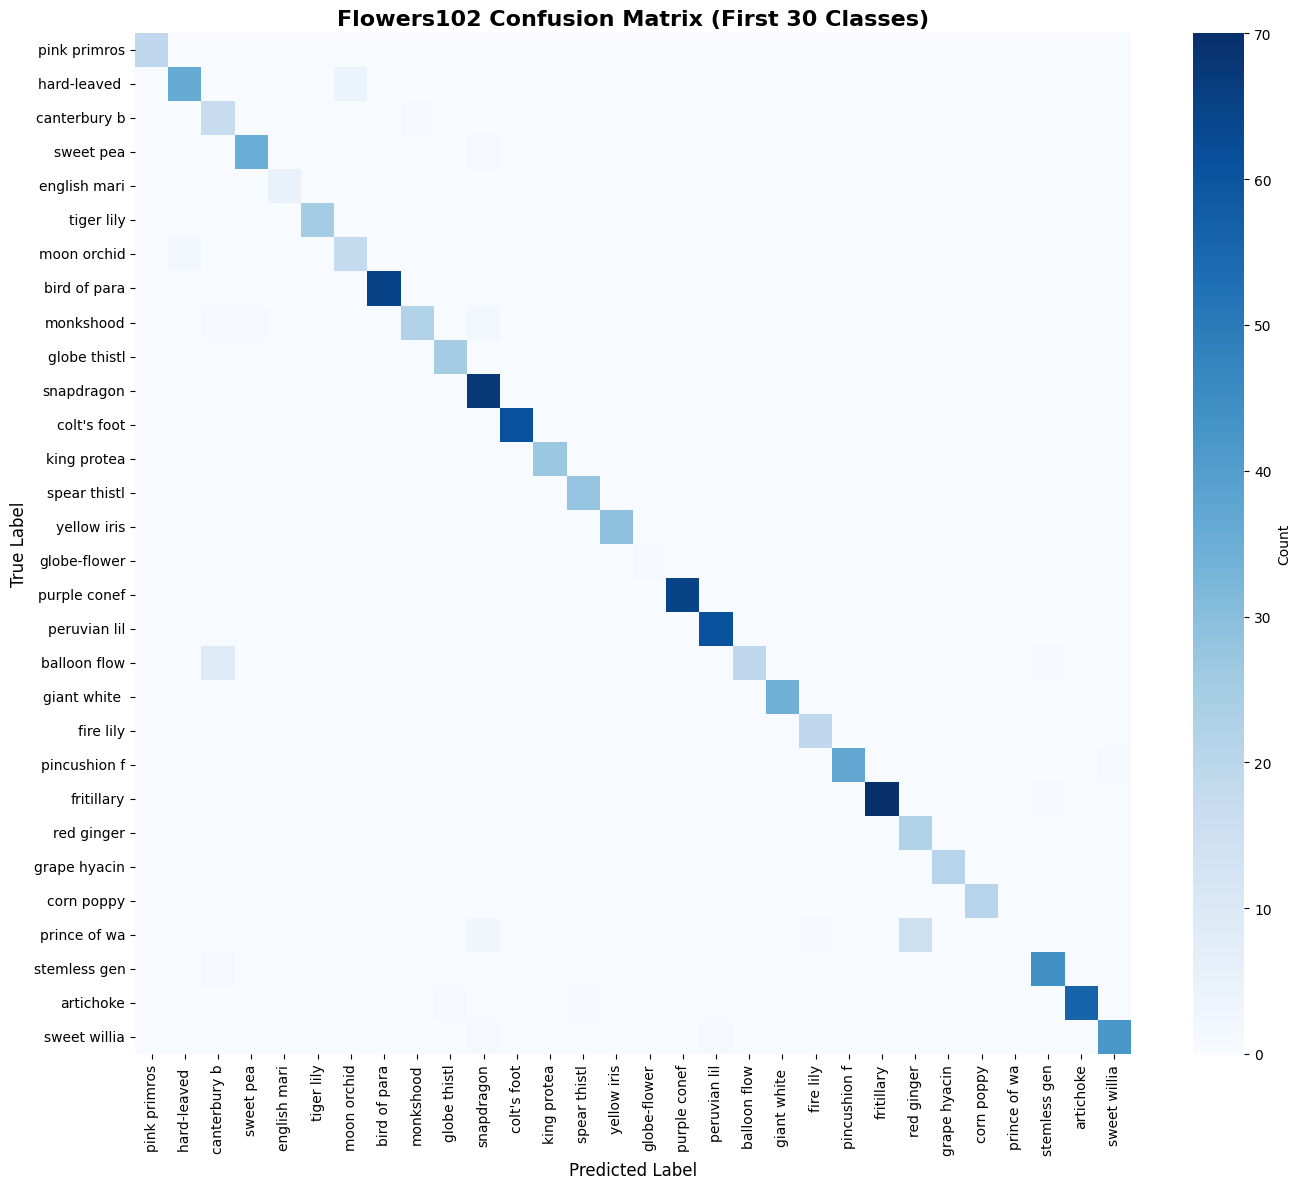

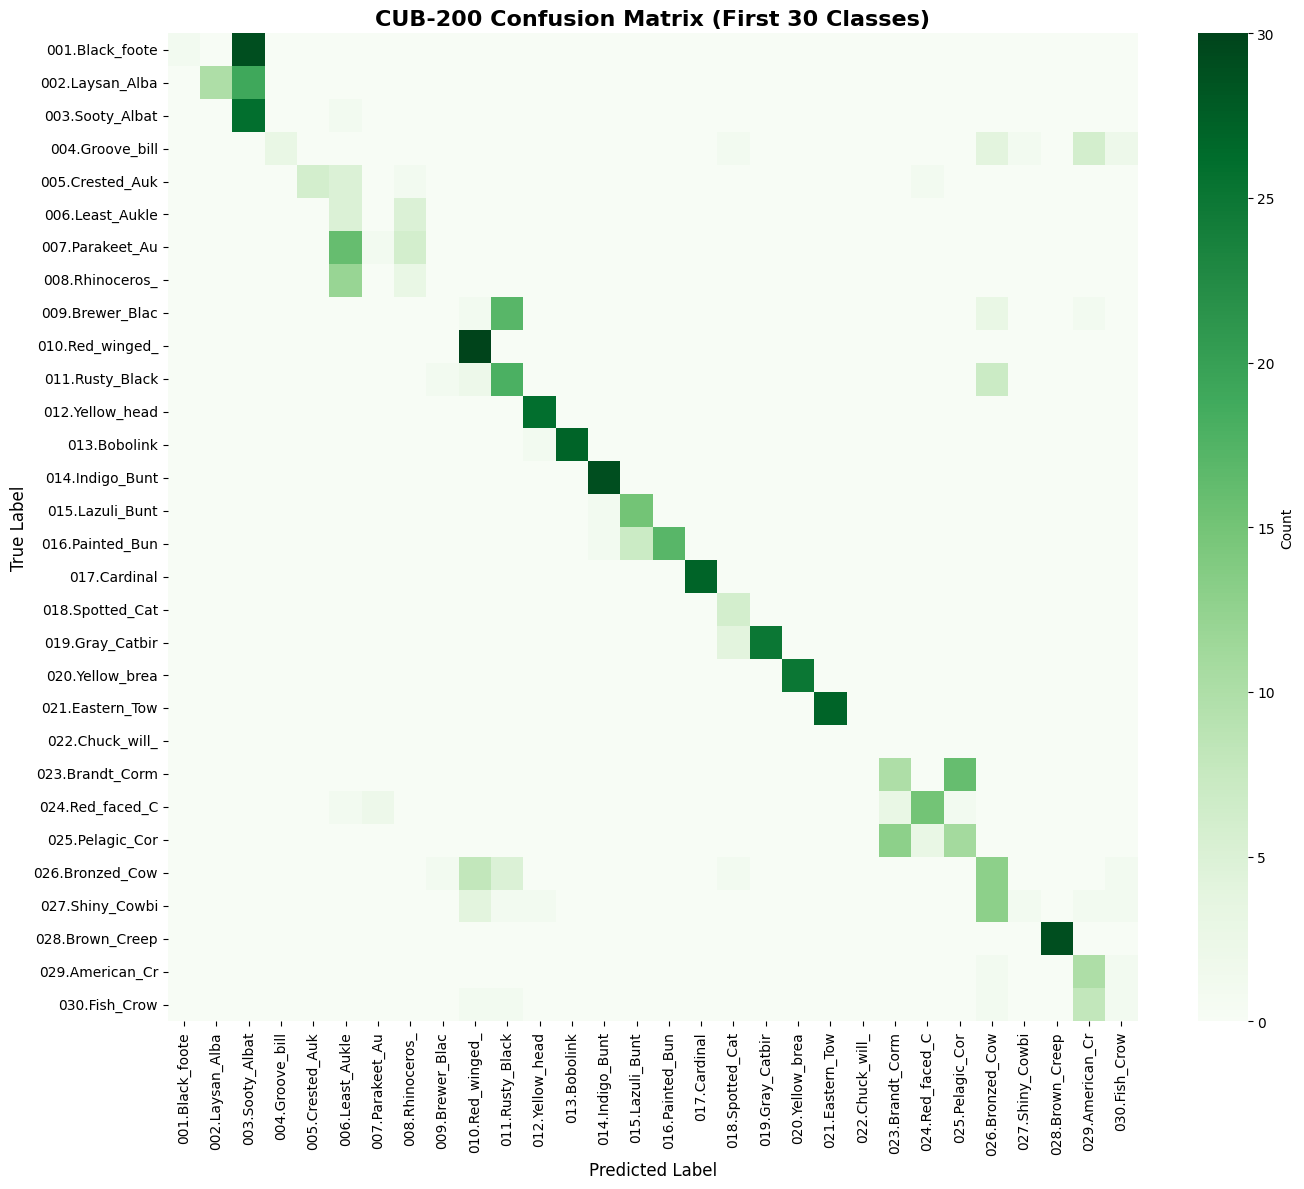

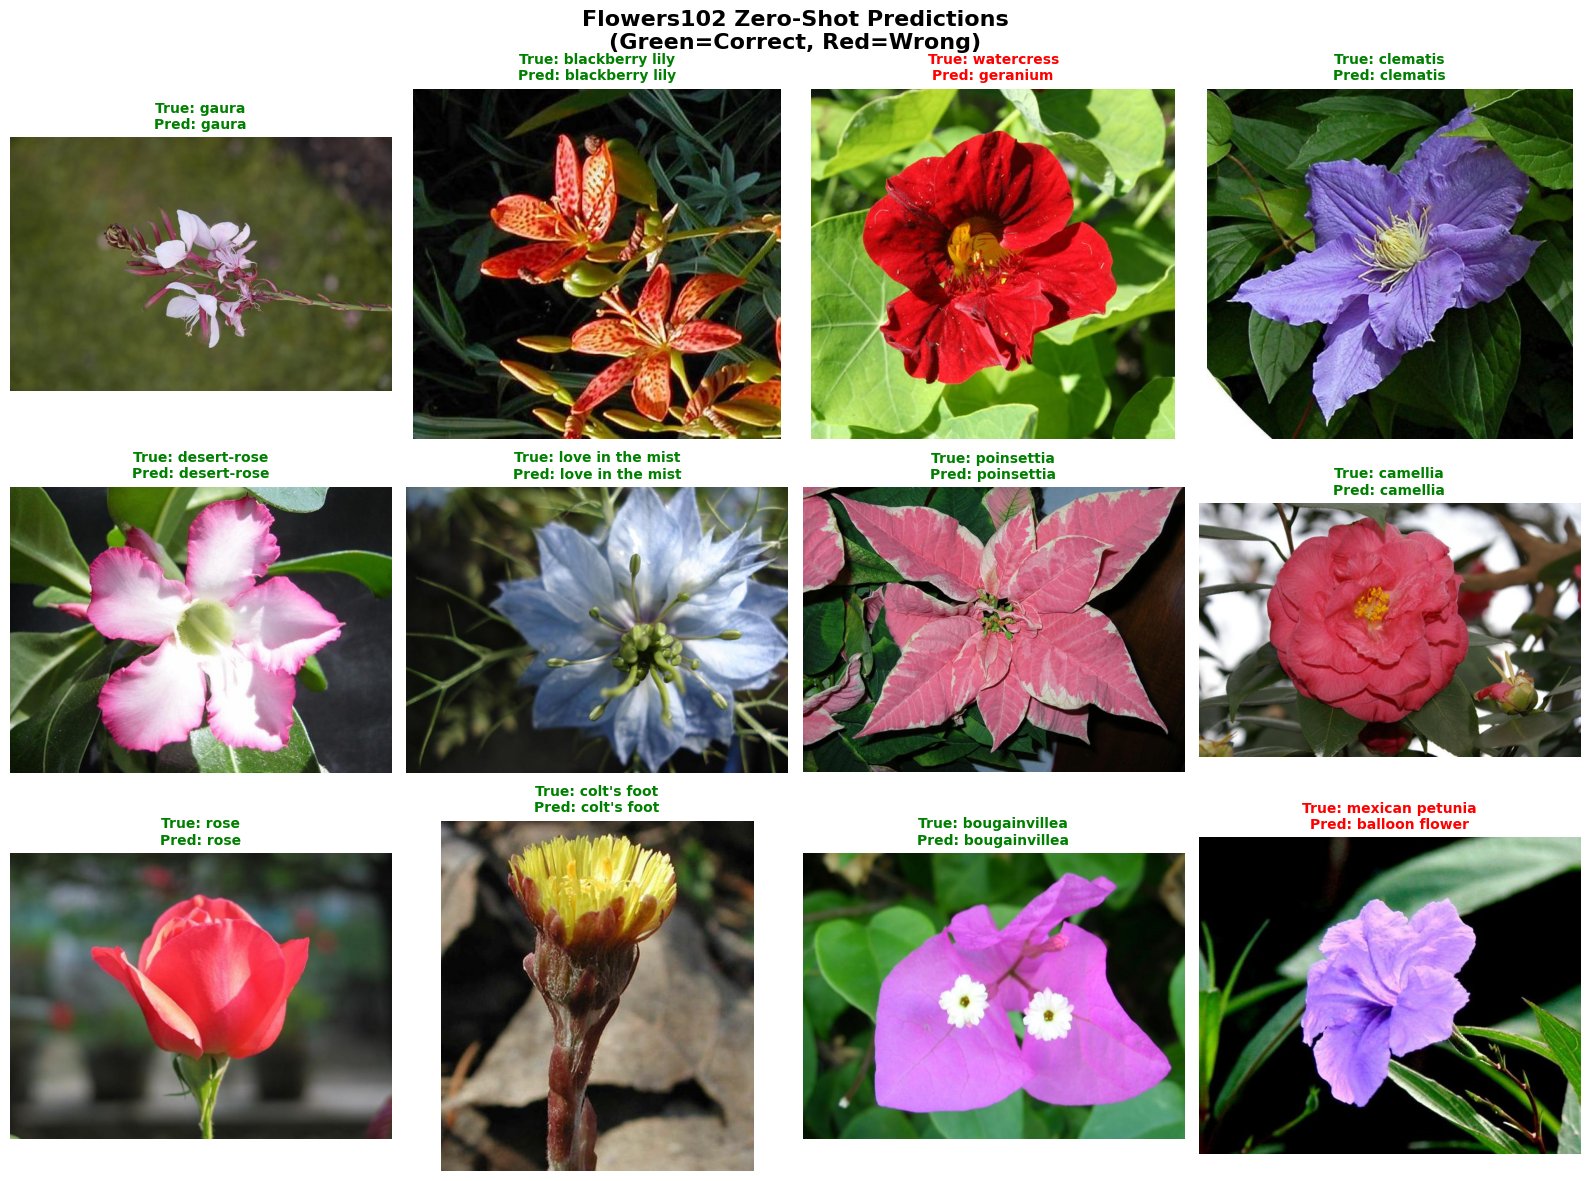

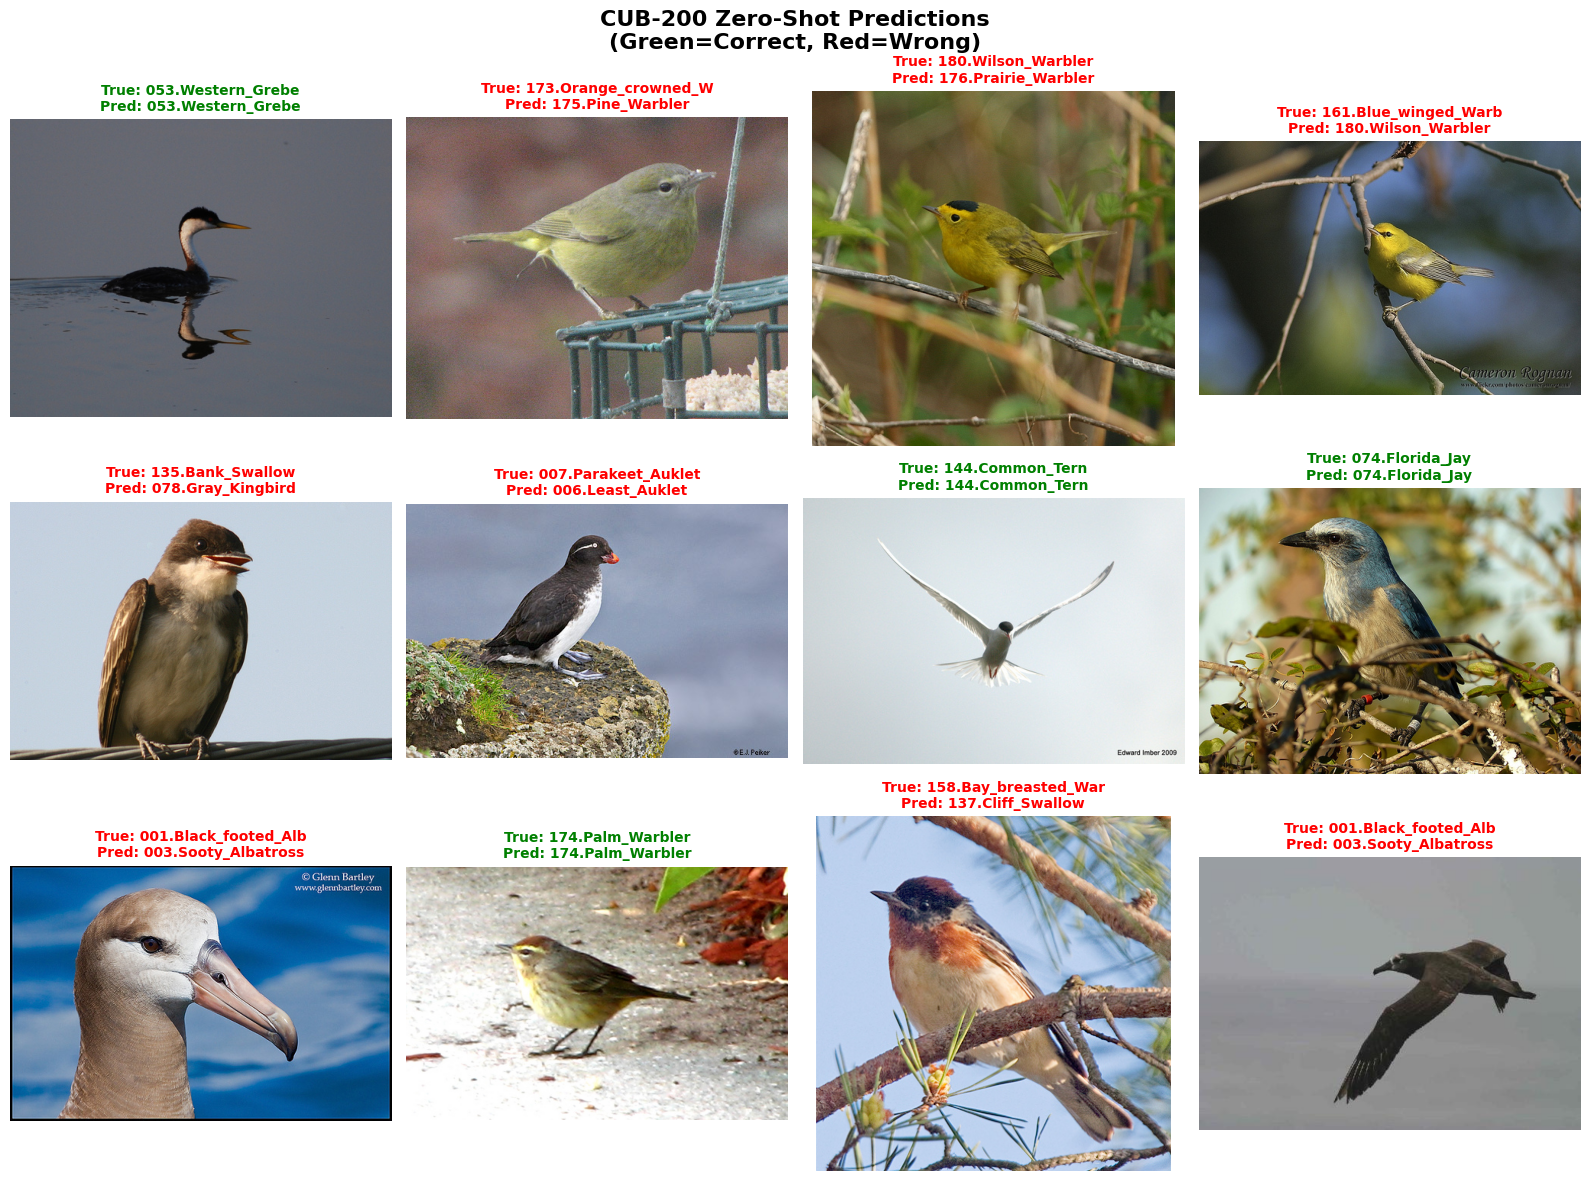


視覺化完成！


In [18]:
# === 6. Visualization ===
# 視覺化
print("--- Visualizing Results ---")

# Confusion Matrix for Flowers102 (show subset)
# Flowers102 混淆矩陣（顯示子集）
plt.figure(figsize=(14, 12))
cm_flowers = confusion_matrix(flowers102_labels, flowers102_predictions, labels=list(range(30)))
sns.heatmap(cm_flowers, annot=False, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'},
            xticklabels=[flowers102_class_names[i][:12] for i in range(30)],
            yticklabels=[flowers102_class_names[i][:12] for i in range(30)])
plt.title('Flowers102 Confusion Matrix (First 30 Classes)', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Confusion Matrix for CUB-200 (show subset)
# CUB-200 混淆矩陣（顯示子集）
plt.figure(figsize=(14, 12))
cm_birds = confusion_matrix(cub_bird_labels, cub_bird_predictions, labels=list(range(30)))
sns.heatmap(cm_birds, annot=False, fmt='d', cmap='Greens', cbar_kws={'label': 'Count'},
            xticklabels=[cub_bird_class_names[i][:15] for i in range(30)],
            yticklabels=[cub_bird_class_names[i][:15] for i in range(30)])
plt.title('CUB-200 Confusion Matrix (First 30 Classes)', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Visualize some predictions for Flowers102
# 視覺化 Flowers102 的預測結果
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

# Get some samples from test set
# 從測試集中取得樣本
np.random.seed(42)  # 固定隨機種子以便重現
sample_indices = np.random.choice(len(flowers102_test_dts), 12, replace=False)

for idx, sample_idx in enumerate(sample_indices):
    # Get original image (without transform for visualization)
    # 獲取原始圖片（不經過轉換，用於視覺化）
    original_dataset = Flowers102(root="./data", split="test", download=False)
    image, true_label = original_dataset[sample_idx]
    
    # Get prediction
    # 獲取預測結果
    pred_label = flowers102_predictions[sample_idx]
    
    axes[idx].imshow(image)
    axes[idx].axis('off')
    title_color = 'green' if pred_label == true_label else 'red'
    axes[idx].set_title(f'True: {flowers102_class_names[true_label][:18]}\n'
                       f'Pred: {flowers102_class_names[pred_label][:18]}',
                       color=title_color, fontsize=10, fontweight='bold')

plt.suptitle('Flowers102 Zero-Shot Predictions\n(Green=Correct, Red=Wrong)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Visualize some predictions for CUB-200
# 視覺化 CUB-200 的預測結果
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

sample_indices = np.random.choice(len(cub_bird_test_dts), 12, replace=False)

for idx, sample_idx in enumerate(sample_indices):
    # Get original image from HuggingFace dataset
    # 從 HuggingFace dataset 獲取原始圖片
    item = birds_200["test"][int(sample_idx)]
    image = item['image']
    true_label = item['label']
    
    # Get prediction
    # 獲取預測結果
    pred_label = cub_bird_predictions[sample_idx]
    
    axes[idx].imshow(image)
    axes[idx].axis('off')
    title_color = 'green' if pred_label == true_label else 'red'
    axes[idx].set_title(f'True: {cub_bird_class_names[true_label][:20]}\n'
                       f'Pred: {cub_bird_class_names[pred_label][:20]}',
                       color=title_color, fontsize=10, fontweight='bold')

plt.suptitle('CUB-200 Zero-Shot Predictions\n(Green=Correct, Red=Wrong)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n視覺化完成！")


### 測試自己拍攝的照片（NTU 校園花卉或鳥類）

請將你在 NTU 拍攝的花卉或鳥類照片放在專案目錄中，並修改下方的 `test_image_path` 變數。


測試自己拍攝的照片

【測試花卉照片】


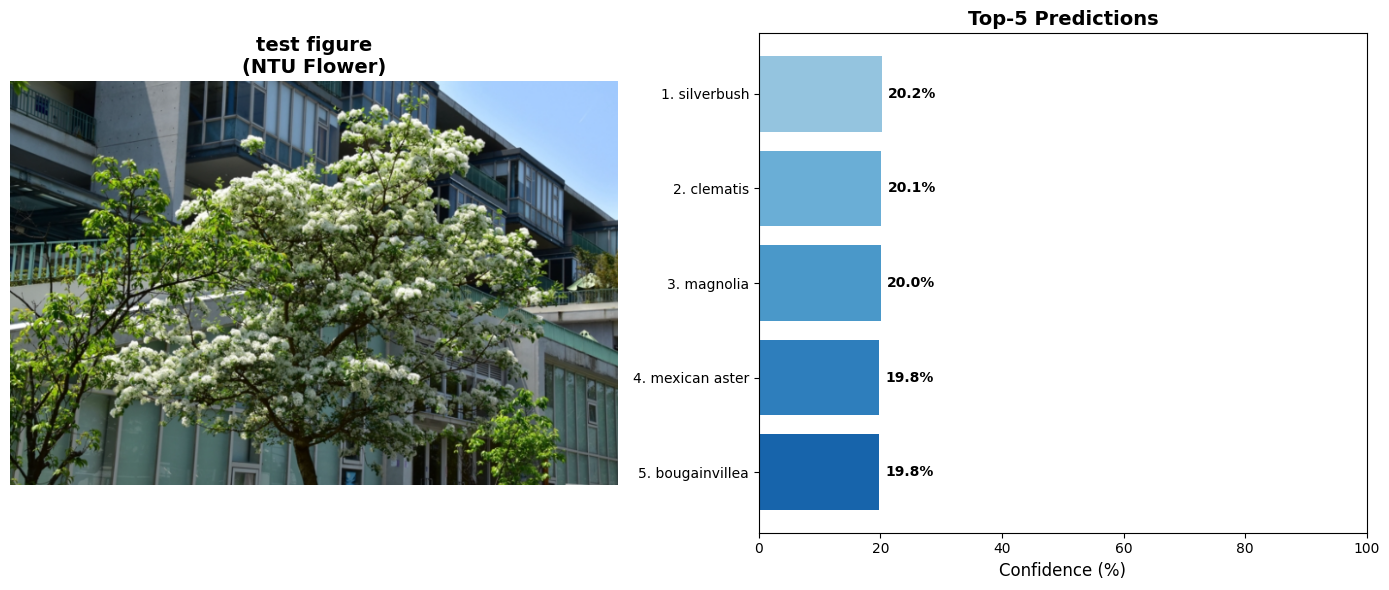


NTU Flower Top-5 預測結果:
1. silverbush                               - 20.24%
2. clematis                                 - 20.15%
3. magnolia                                 - 20.03%
4. mexican aster                            - 19.81%
5. bougainvillea                            - 19.78%

【測試鳥類照片】


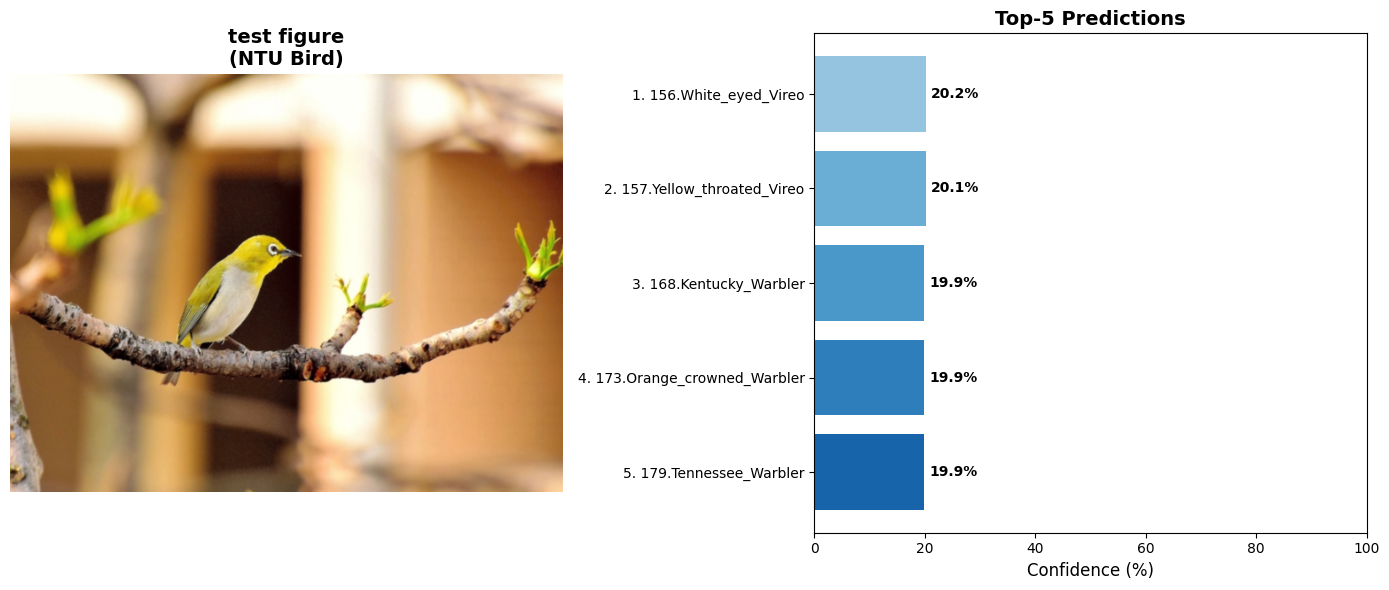


NTU Bird Top-5 預測結果:
1. 156.White_eyed_Vireo                     - 20.16%
2. 157.Yellow_throated_Vireo                - 20.14%
3. 168.Kentucky_Warbler                     - 19.91%
4. 173.Orange_crowned_Warbler               - 19.90%
5. 179.Tennessee_Warbler                    - 19.90%


In [14]:
# === 7. 測試自己拍攝的照片 ===
from PIL import Image
import os

def test_custom_image(image_path, model, processor, class_names, text_features, dataset_name=""):
    """
    測試自訂圖片
    Args:
        image_path: 圖片路徑
        model: CLIP 模型
        processor: CLIP processor
        class_names: 類別名稱列表
        text_features: 預先計算的文字特徵
        dataset_name: 資料集名稱（用於顯示）
    """
    if not os.path.exists(image_path):
        print(f"錯誤：找不到圖片 {image_path}")
        print("請將你拍攝的照片放在專案目錄中，並更新路徑。")
        return
    
    # 載入並預處理圖片
    image = Image.open(image_path).convert('RGB')
    image_input = processor(images=image, return_tensors="pt")["pixel_values"].to(DEVICE)
    
    # 進行預測
    with torch.no_grad():
        image_features = model.get_image_features(pixel_values=image_input)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        
        # 計算相似度
        similarity = (image_features @ text_features.T)
        
        # 取得 top-5 預測
        top5_prob, top5_idx = torch.topk(similarity, 5, dim=-1)
        top5_prob = torch.softmax(top5_prob, dim=-1)
    
    # 視覺化結果
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # 顯示圖片
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title(f'test figure\n({dataset_name})', fontsize=14, fontweight='bold')
    
    # 顯示 top-5 預測
    top5_names = [class_names[idx] for idx in top5_idx[0].cpu().numpy()]
    top5_probs = top5_prob[0].cpu().numpy() * 100
    
    colors = plt.cm.Blues(np.linspace(0.4, 0.8, 5))
    bars = ax2.barh(range(5), top5_probs, color=colors)
    ax2.set_yticks(range(5))
    ax2.set_yticklabels([f"{i+1}. {name[:30]}" for i, name in enumerate(top5_names)])
    ax2.set_xlabel('Confidence (%)', fontsize=12)
    ax2.set_title('Top-5 Predictions', fontsize=14, fontweight='bold')
    ax2.invert_yaxis()
    ax2.set_xlim([0, 100])
    
    # 在柱狀圖上標示數值
    for i, (bar, prob) in enumerate(zip(bars, top5_probs)):
        ax2.text(prob + 1, i, f'{prob:.1f}%', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{dataset_name} Top-5 預測結果:")
    print("="*60)
    for i, (name, prob) in enumerate(zip(top5_names, top5_probs)):
        print(f"{i+1}. {name:40s} - {prob:.2f}%")
    print("="*60)

# 測試範例
# 請將以下路徑改為你實際拍攝的照片路徑
test_image_path_flower = "my_photo/flower.png"  # 修改為你的花卉照片路徑
test_image_path_bird = "my_photo/bird.png"      # 修改為你的鳥類照片路徑

print("\n" + "="*80)
print("測試自己拍攝的照片")
print("="*80)

# 測試花卉照片
if os.path.exists(test_image_path_flower):
    print("\n【測試花卉照片】")
    test_custom_image(test_image_path_flower, model, processor, 
                     flowers102_class_names, flowers_text_features_default, 
                     "NTU Flower")
else:
    print(f"\n未找到花卉照片: {test_image_path_flower}")
    print("請拍攝 NTU 校園的花卉照片並更新路徑")

# 測試鳥類照片
if os.path.exists(test_image_path_bird):
    print("\n【測試鳥類照片】")
    test_custom_image(test_image_path_bird, model, processor,
                     cub_bird_class_names, birds_text_features_default,
                     "NTU Bird")
else:
    print(f"\n未找到鳥類照片: {test_image_path_bird}")
    print("請拍攝 NTU 校園的鳥類照片並更新路徑")
